# Benchmark Modell MPA

In [375]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [189]:
#Import data
df_mpa = pd.read_csv("../data/data_mpa.txt", sep=" ")
df_spg = pd.read_csv("../data/data_spg.txt", sep=" ")
df_sps = pd.read_csv("../data/data_sps.txt", sep=" ")

## Attribute filtern

In [190]:
tmp = df_mpa.corr(method='spearman')['size_mm']
tmp = tmp[~tmp.index.isin(['size_mm'])]
tmp = tmp.abs().sort_values(ascending=False)
tmp.head(5)

centroid_frequency_M04     0.772877
centroid_frequency2_M04    0.764935
centroid_frequency_M02     0.756375
median_freq_M04            0.754218
centroid_frequency_M01     0.751949
Name: size_mm, dtype: float64

Für das einfache Modell werden wir nur die Features nehmen, die auch stark mit der Korngrösse Korrelieren.

Aus diesem Grund nehmen wir nur die centroid frequency für den Benchmark.

In [191]:
filter_col = [col for col in df_mpa if col.startswith('centroid_frequency')]
filter_col.append("size_mm")
df_mpa = df_mpa[filter_col]

In [192]:
df_mpa.shape

(21663, 9)

Der neue Datensatz hat jetzt nur noch 9 Attribute (inklusiv die Zielvariable)

## Transformation

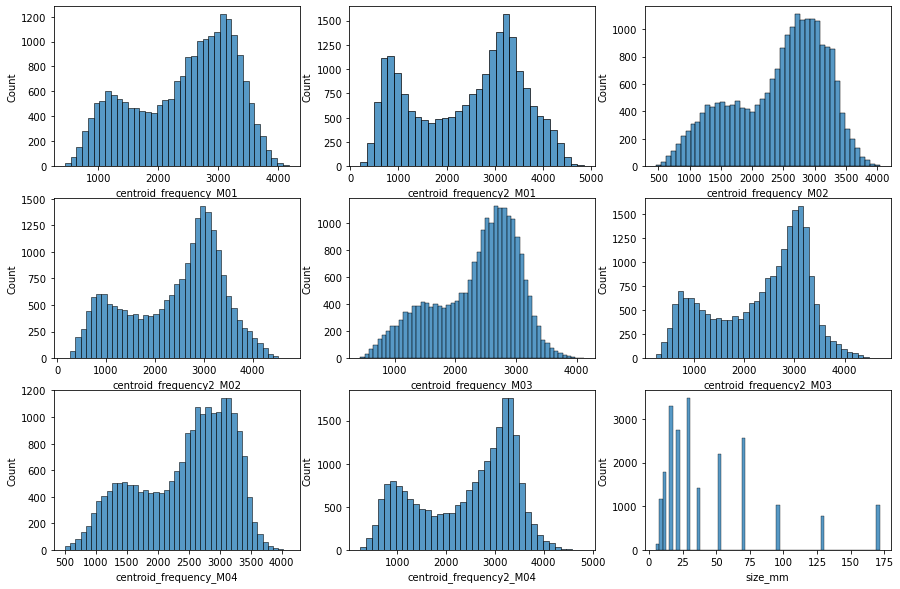

In [193]:
fig = plt.subplots(figsize=(15, 10))

for k in range(df_mpa.shape[1]):
    plt.subplot(3,3,k+1)
    sns.histplot(df_mpa.iloc[:, k])
    
plt.show()

Zurzeit haben wir überall eine bimodale Verteilung der Daten aus bei der Zielvaribale (size_mm).

Wir würden gerne die Zielbariable logarithmieren.

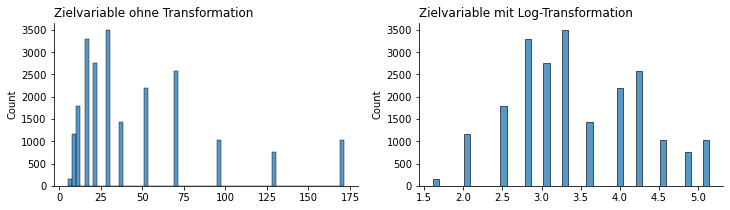

In [354]:
fig = plt.subplots(1, 2, figsize=(12, 3))
tmp = df_mpa['size_mm'].to_numpy()
plt.subplot(1,2,1)
p = sns.histplot(tmp)
p.set_title('Zielvariable ohne Transformation', loc='left')
plt.subplot(1,2,2)
p = sns.histplot(np.log(tmp))
p.set_title('Zielvariable mit Log-Transformation', loc='left')
sns.despine()
plt.show()

Der Plot zeigt, dass durch die empfohlene Transformation die Korngrösse normalverteilter gemacht wird. Durch die Transformation könnte durchaus eine Verbesserung des Modells erreicht werden.

## Benchmark Lineares Modell

In [330]:
df_mpa = df_mpa.sample(frac = 1).reset_index(drop = True)

In [331]:
X, y = df_mpa.drop(['size_mm'], axis=1), np.log(df_mpa['size_mm'])

In [363]:
model = LinearRegression()
model.fit(X,y)
cvs = cross_val_score(model, X, y, cv=5)
np.mean(cvs)

0.7147425705180664

In [394]:
y_pred = model.predict(X)
res = y_pred-y

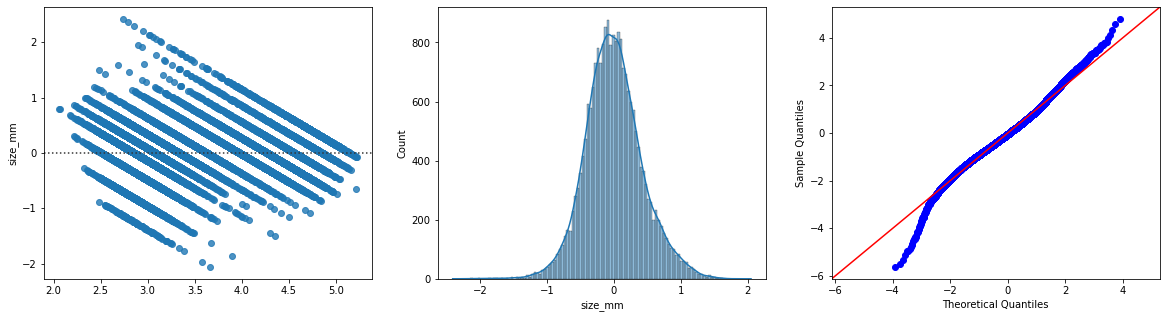

In [395]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))

sns.residplot(x=y_pred,y=y,ax=ax[0])

sns.histplot(res,kde=True,ax=ax[1])

sm.qqplot(res, fit=True, line="45", ax=ax[2])
plt.show()